In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

from src.clients.solana.meteora import SolanaMeteoraClient
from src.utils.analyzer import Analyzer
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mpl_dates
import pandas as pd

from mplfinance.original_flavor import candlestick_ohlc


client = SolanaMeteoraClient()


Setting API URL: https://dlmm-api.meteora.ag
Setting RPC: https://api.mainnet-beta.solana.com
Creating session...
Session headers set: {'User-Agent': 'python-requests/2.32.3', 'Accept-Encoding': 'gzip, deflate', 'Accept': 'application/json', 'Connection': 'keep-alive', 'Content-type': 'application/json', 'rpc': 'https://api.mainnet-beta.solana.com'}
Using CoinGecko demo API key: CG-2...
Fetching CoinGecko coin list for mint mapping...
Requesting: https://api.coingecko.com/api/v3/coins/list?include_platform=true with headers: {'accept': 'application/json', 'x-cg-demo-api-key': 'CG-2ZhP7B4uMGefQbTC6HyNWmcv'}
Received 17166 coins from CoinGecko
Sample coin entries: [{'id': '_', 'symbol': 'gib', 'name': '༼ つ ◕_◕ ༽つ', 'platforms': {'hedera-hashgraph': '0x00000000000000000000000000000000007872cb'}}, {'id': '01coin', 'symbol': 'zoc', 'name': '01coin', 'platforms': {}}, {'id': '0chain', 'symbol': 'zcn', 'name': 'Zus', 'platforms': {'ethereum': '0xb9ef770b6a5e12e45983c5d80545258aa38f3b78', 'pol

In [2]:
# Fetch and filter pools
pairs = client.fetch_liquidity_pools()
min_tvl = 10000
min_volume = 5000
filtered_pairs = client.filter_pairs(pairs, min_tvl=min_tvl, min_volume=min_volume)
print(f"Filtered pairs (TVL >= {min_tvl}, Volume >= {min_volume}): {len(filtered_pairs)}")
for pair in filtered_pairs[:5]:
    print(pair)

Fetching pools from https://dlmm-api.meteora.ag/pair/all
Status code: 200
Total pools in response: 69085
Sample pool: {'address': 'ChtaSJP37nke53EGe7FWgRCShffXapUijKxyKPNsY4Q7', 'name': '$slop-SOL', 'mint_x': 'FqvtZ2UFR9we82Ni4LeacC1zyTiQ77usDo31DUokpump', 'mint_y': 'So11111111111111111111111111111111111111112', 'reserve_x': 'BXYFA5fadDtLLEpF2tjrSp6kuSzSbd1wf7fJGnQbX4mM', 'reserve_y': 'A7hBbcEKv8v9AgcGUZR2eDqAgWj7eKmCimUsqZgy1TYP', 'reserve_x_amount': 303598071, 'reserve_y_amount': 2856, 'bin_step': 200, 'base_fee_percentage': '2', 'max_fee_percentage': '8.75', 'protocol_fee_percentage': '5', 'liquidity': '3.2118149707583648', 'reward_mint_x': '11111111111111111111111111111111', 'reward_mint_y': '11111111111111111111111111111111', 'fees_24h': 0.0, 'today_fees': 0.0, 'trade_volume_24h': 0.0, 'cumulative_trade_volume': '484032.8700', 'cumulative_fee_volume': '18165.4500', 'current_price': 6.902029515279097e-05, 'apr': 0.0, 'apy': 0.0, 'farm_apr': 0.0, 'farm_apy': 0.0, 'hide': False, 'is_

In [3]:
# Extract tokens with tickers
token_map = {}  # {mint: ticker}
for pair in filtered_pairs:
    token_map[pair.token0_address] = pair.token0_symbol
    token_map[pair.token1_address] = pair.token1_symbol

tokens = set(token_map.keys())
tokens.add("So11111111111111111111111111111111111111112")  # SOL, default ticker "SOL"
token_map["So11111111111111111111111111111111111111112"] = "SOL"
print(f"Tokens to analyze: {len(tokens)}")

Tokens to analyze: 67


Fetching price history for orbit-3 (mint: GekTNfm84QfyP2GdAHZ5AgACBRd69aNmgA5FDhZupump, ticker: GRIFT) from CoinGecko
Requesting: https://api.coingecko.com/api/v3/coins/orbit-3/ohlc?vs_currency=usd&days=30 with headers: {'accept': 'application/json', 'x-cg-demo-api-key': 'CG-2ZhP7B4uMGefQbTC6HyNWmcv'}
Raw OHLC data sample: [[1737835200000, 0.107713, 0.123368, 0.106407, 0.121331], [1737849600000, 0.118315, 0.121756, 0.105091, 0.106242]]
Columns after fetch: ['timestamp', 'open', 'high', 'low', 'close', 'volume']
Fetched 180 price bars for GekTNfm84QfyP2GdAHZ5AgACBRd69aNmgA5FDhZupump (4-hour intervals)
PriceBar columns for GRIFT (GekTNfm8...): ['timestamp', 'open', 'high', 'low', 'close', 'volume']
Fetching price history for drift-staked-sol (mint: Dso1bDeDjCQxTrWHqUUi63oBvV7Mdm6WaobLbQ7gnPQ, ticker: dSOL) from CoinGecko
Requesting: https://api.coingecko.com/api/v3/coins/drift-staked-sol/ohlc?vs_currency=usd&days=30 with headers: {'accept': 'application/json', 'x-cg-demo-api-key': 'CG-2Z

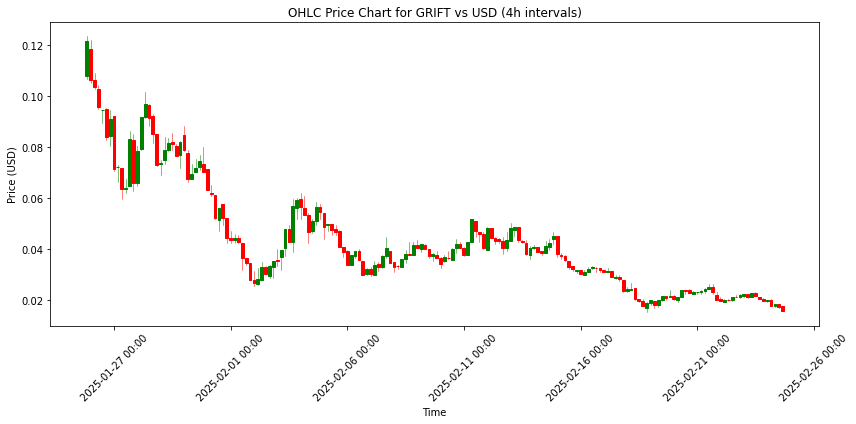

In [4]:
# Fetch price history with tickers
price_bars = []
for token in tokens:
    ticker = token_map.get(token, "UNKNOWN")
    pb = client.get_price_bars(token, "USD",days=30, token_symbol=ticker)
    print(f"PriceBar columns for {ticker} ({token[:8]}...): {pb.data.columns.tolist()}")
    price_bars.append(pb)

# Print and plot first price bar
if price_bars:
    first_token = price_bars[0]
    print(f"\nPrice bar for first token ({first_token.token_symbol} vs {first_token.base_token}):")
    print(first_token.data.head())

    plot_data = first_token.data[["timestamp", "open", "high", "low", "close"]].copy()
    plot_data["timestamp"] = pd.to_datetime(plot_data["timestamp"])
    plot_data["timestamp"] = plot_data["timestamp"].map(pd.Timestamp.to_pydatetime).map(mpl_dates.date2num)

    fig, ax = plt.subplots(figsize=(12, 6))
    candlestick_ohlc(ax, plot_data.values, width=0.12, colorup='g', colordown='r')
    ax.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d %H:%M"))
    plt.title(f"OHLC Price Chart for {first_token.token_symbol} vs {first_token.base_token} (4h intervals)")
    plt.xlabel("Time")
    plt.ylabel("Price (USD)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:

    print("No price bars fetched")





In [5]:
# Compute correlation matrix for all pairs
correlation_matrix = Analyzer.compute_correlation_matrix(price_bars)
print("\nCorrelation Matrix (All Pairs):")
print(correlation_matrix)

Insufficient overlapping data for correlation with ±10-minute window (rows: 0)

Correlation Matrix (All Pairs):
               GRIFT_vs_USD  dSOL_vs_USD  DOLAN_vs_USD  SPX_vs_USD  \
GRIFT_vs_USD            NaN          NaN           NaN         NaN   
dSOL_vs_USD             NaN          NaN           NaN         NaN   
DOLAN_vs_USD            NaN          NaN           NaN         NaN   
SPX_vs_USD              NaN          NaN           NaN         NaN   
WEN_vs_USD              NaN          NaN           NaN         NaN   
...                     ...          ...           ...         ...   
MAX_vs_USD              NaN          NaN           NaN         NaN   
Anon_vs_USD             NaN          NaN           NaN         NaN   
SNAI_vs_USD             NaN          NaN           NaN         NaN   
POPCAT_vs_USD           NaN          NaN           NaN         NaN   
POLIS_vs_USD            NaN          NaN           NaN         NaN   

               WEN_vs_USD  SPERG_vs_USD  INF_vs